In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.optimize import minimize

#Au material script from complex refractive index data

wvl_data = np.array([250.000000, 260.000000, 270.000000, 280.000000, 290.000000, 300.000000,
                              310.000000, 320.000000, 330.000000, 340.000000, 350.000000, 360.000000,
                              370.000000, 380.000000, 390.000000, 400.000000, 410.000000, 420.000000,
                              430.000000, 440.000000, 450.000000, 460.000000, 470.000000, 480.000000,
                              490.000000, 500.000000, 510.000000, 520.000000, 530.000000, 540.000000,
                              550.000000, 560.000000, 570.000000, 580.000000, 590.000000, 600.000000,
                              610.000000, 620.000000, 630.000000, 640.000000, 650.000000, 660.000000,
                              670.000000, 680.000000, 690.000000, 700.000000, 710.000000, 720.000000,
                              730.000000, 740.000000, 750.000000, 760.000000, 770.000000, 780.000000,
                              790.000000, 800.000000, 810.000000, 820.000000, 830.000000, 840.000000,
                              850.000000, 860.000000, 870.000000, 880.000000, 890.000000, 900.000000,
                              910.000000, 920.000000, 930.000000, 940.000000, 950.000000, 960.000000,
                              970.000000, 980.000000, 990.000000, 1000.000000])

#Refractive index data
n_data = np.array([1.486293, 1.517101, 1.602219, 1.678100, 1.750429, 1.800042, 1.830000, 1.836011,
                   1.813111, 1.781199, 1.751161, 1.726732, 1.706249, 1.687926, 1.670782, 1.658000,
                   1.641467, 1.626593, 1.607286, 1.572004, 1.503407, 1.417996, 1.315496, 1.189871,
                   1.018554, 0.849238, 0.698231, 0.571152, 0.475555, 0.397920, 0.355713, 0.318417,
                   0.295010, 0.278152, 0.261664, 0.245531, 0.229740, 0.214278, 0.199131, 0.184288,
                   0.169737, 0.164060, 0.162125, 0.160792, 0.160087, 0.160906, 0.161863, 0.162930,
                   0.164154, 0.166357, 0.168557, 0.170750, 0.172934, 0.175425, 0.178189, 0.180917,
                   0.183609, 0.186265, 0.189334, 0.193206, 0.197006, 0.200737, 0.204403, 0.208008,
                   0.211773, 0.215750, 0.219658, 0.223500, 0.227279, 0.230997, 0.234659, 0.239028,
                   0.243770, 0.248435, 0.253026, 0.257546])

#Absorption coefficient data (imaginary coefficient of complex refractive index)
k_data = np.array([1.660980, 1.759202, 1.824512, 1.873471, 1.904443, 1.919298, 1.916000, 1.897531,
                   1.870450, 1.852625, 1.847116, 1.855697, 1.883198, 1.916907, 1.939990, 1.956000,
                   1.957488, 1.949527, 1.934151, 1.910625, 1.878436, 1.843614, 1.814717, 1.799925,
                   1.820950, 1.892178, 2.027084, 2.185897, 2.374957, 2.553141, 2.695668, 2.832206,
                   2.899935, 2.930925, 2.961718, 2.992315, 3.022714, 3.052916, 3.082919, 3.112725,
                   3.142334, 3.293285, 3.477580, 3.652616, 3.817434, 3.959739, 4.097111, 4.230027,
                   4.358280, 4.474892, 4.588542, 4.699445, 4.807792, 4.914824, 5.020584, 5.124162,
                   5.225688, 5.325278, 5.419440, 5.505117, 5.589481, 5.672590, 5.754499, 5.835259,
                   5.919898, 6.009588, 6.097960, 6.185070, 6.270970, 6.355709, 6.439333, 6.519685,
                   6.597783, 6.674968, 6.751271, 6.826722])


#Fit the data to Lorentz Function and generate Au material

def lorentzfunc(p: np.ndarray, x: np.ndarray) -> np.ndarray:
    """
    Returns the complex ε profile given a set of Lorentzian parameters p
    (σ_0, ω_0, γ_0, σ_1, ω_1, γ_1, ...) for a set of frequencies x.
    """
    N = len(p) // 3
    y = np.zeros(len(x))
    for n in range(N):
        A_n, x_n, g_n = p[3 * n : 3 * n + 3]
        y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)
    return y


def lorentzerr(p: np.ndarray, x: np.ndarray, y: np.ndarray) -> float:
    """
    Returns the error (or residual or loss) as the L2 norm
    of the difference of ε(p,x) and y over a set of frequencies x.
    """
    yp = lorentzfunc(p, x)
    val = np.sum(np.square(abs(y - yp)))
    return val


def lorentzfit(
    p0: np.ndarray,
    x: np.ndarray,
    y: np.ndarray,
    tol: float = 1e-25,
    maxeval: float = 10000,
) -> Tuple[np.ndarray, float]:
    """
    Returns the optimal Lorentzian polarizability parameters and error
    which minimize the error in ε(p0,x) relative to y for an initial
    set of Lorentzian polarizability parameters p0 over a set of
    frequencies x using the scipy.optimize algorithm for a relative
    tolerance tol and a maximum number of iterations maxeval.
    """
    result = minimize(
        lambda p: lorentzerr(p, x, y),
        p0,
        method="L-BFGS-B",
        options={"ftol": tol, "maxiter": maxeval},
    )
    popt = result.x
    minf = result.fun
    return popt, minf


if __name__ == "__main__":
    
    n = n_data[:] + 1j * k_data[:]
    eps_inf = 1.1

    eps = np.square(n) - eps_inf

    wl = wvl_data[:]
    wl_min = 250  # minimum wavelength (units of nm)
    wl_max = 1000  # maximum wavelength (units of nm)
    start_idx = np.where(wl > wl_min)
    idx_start = start_idx[0][0]
    end_idx = np.where(wl < wl_max)
    idx_end = end_idx[0][-1] + 1

    # The fitting function is ε(f) where f is the frequency, rather than ε(λ).
    freqs = 1000 / wl  # units of 1/μm
    freqs_reduced = freqs[idx_start:idx_end]
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps[idx_start:idx_end]

    # Fitting parameter: number of Lorentzian terms to use in the fit
    num_lorentzians = 2

    # Number of times to repeat local optimization with random initial values.
    num_repeat = 30

    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)
    for m in range(num_repeat):
        # Initial values for the Lorentzian polarizability terms. Each term
        # consists of three parameters (σ, ω, γ) and is chosen randomly.
        # Note: for the case of no absorption, γ should be set to zero.
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(p_rand, freqs_reduced, eps_reduced, 1e-25, 50000)
        ps_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[m, :]) + " )"
        print(f"iteration:, {m:3d}, ps_str, {mins[m]:.6f}")

    # Find the best performing set of parameters.
    idx_opt = np.argmin(mins)
    popt_str = "( " + ", ".join(f"{prm:.4f}" for prm in ps[idx_opt]) + " )"
    print(f"optimal:, {popt_str}, {mins[idx_opt]:.6f}")

    # Define a `Medium` class object using the optimal fitting parameters.
    E_susceptibilities = []

    for n in range(num_lorentzians):
        mymaterial_freq, mymaterial_gamma = ps[idx_opt][3 * n + 1:3 * n + 3]

        if mymaterial_freq == 0:
            mymaterial_sigma = ps[idx_opt][3 * n + 0]
            E_susceptibilities.append(
                mp.DrudeSusceptibility(
                    frequency=1.0, gamma=mymaterial_gamma, sigma=mymaterial_sigma
                )
            )
        else:
            mymaterial_sigma = ps[idx_opt][3 * n + 0] / mymaterial_freq**2
            E_susceptibilities.append(
                mp.LorentzianSusceptibility(
                    frequency=mymaterial_freq,
                    gamma=mymaterial_gamma,
                    sigma=mymaterial_sigma,
                )
            )

    Au = mp.Medium(epsilon=eps_inf, E_susceptibilities=E_susceptibilities)
    

iteration:,   0, ps_str, 13046.694866
iteration:,   1, ps_str, 1281.858184
iteration:,   2, ps_str, 13044.888708
iteration:,   3, ps_str, 148.081582
iteration:,   4, ps_str, 13044.555289
iteration:,   5, ps_str, 148.081582
iteration:,   6, ps_str, 148.081582
iteration:,   7, ps_str, 13045.429829
iteration:,   8, ps_str, 13043.252663
iteration:,   9, ps_str, 148.081582
iteration:,  10, ps_str, 13043.853336
iteration:,  11, ps_str, 13048.312907
iteration:,  12, ps_str, 148.081582
iteration:,  13, ps_str, 13050.616823
iteration:,  14, ps_str, 13049.307665
iteration:,  15, ps_str, 1282.150340
iteration:,  16, ps_str, 1075.787014
iteration:,  17, ps_str, 301.195446
iteration:,  18, ps_str, 148.081582
iteration:,  19, ps_str, 148.081582
iteration:,  20, ps_str, 13048.135401
iteration:,  21, ps_str, 1282.148396
iteration:,  22, ps_str, 148.081582
iteration:,  23, ps_str, 13045.848767
iteration:,  24, ps_str, 148.081582
iteration:,  25, ps_str, 148.081582
iteration:,  26, ps_str, 13044.233171


In [2]:
#Coupling field enhancement

import meep as mp
import numpy as np
import matplotlib.pyplot as plt



def get_incident_value(cell_size, resolution, sources, pml_layers, d):

    print("$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$")
    
    default_material = mp.Medium(index=1.3325)

    resolution = 4/r

    sim = mp.Simulation(
            resolution=resolution,
            cell_size=cell_size,
            boundary_layers=pml_layers,
            sources=sources,
            k_point=mp.Vector3()
        )
    
    sim.run(until=10) #10 fs

    d=0.3*d

    Ez_data_1D = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(y=d), component=mp.Ey))

    return Ez_data_1D[0]



def get_sphere_coupling_enhancement(r, gap, wvl):
    
    #default medium is water
    default_material = mp.Medium(index=1.3325)
    
    frq = 1 / wvl

    #50/r?
    resolution = 100/r
    
    dpml = 2*r
    dair = 2*r
    #defining gap between spheres. Can adjust later.
    
    pml_layers = [mp.PML(thickness=dpml)]
    
    #Fine to keep these since the system is still symmetric relative to these planes.
    #symmetries = [mp.Mirror(mp.Y)]
    
    width = 2 * (dpml + dair + r)
    height = 2 * (dpml + dair + 2*r + 0.5*gap)
    cell_size = mp.Vector3(width, height)
    
    # is_integrated=True necessary for any planewave source extending into PML
    sources = [
        mp.Source(
            mp.ContinuousSource(frequency=frq, is_integrated=True),
            center=mp.Vector3(-0.5*width + dpml, 0),
            size=mp.Vector3(0, height),
            component=mp.Hz,
        )
    ]
    
    
    
    geometry = [
        mp.Sphere(material=Au,
                  center=mp.Vector3(0, 0.5*gap + r),
                  radius=r),
        mp.Sphere(material=Au,
                  center=mp.Vector3(0, -0.5*gap - r),
                  radius=r),
    ]
    
    
    sim = mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=pml_layers,
        sources=sources,
        k_point=mp.Vector3(),
        geometry=geometry,
    )
    
    
    sim.run(until=10) #10 fs
    
    #grab data once run is finished i.e. what the system looks like at 200fs:
    d = 0.95*(height-2*dpml)
    w = width-2*dpml

    Ez_data_1D = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(y=d), component=mp.Ey))

    incident_field_value = get_incident_value(cell_size, resolution, sources, pml_layers, d)

    eps_data_x = sim.get_array(center=mp.Vector3(), size=mp.Vector3(w, d), component=mp.Dielectric)
    Ex_data = np.absolute(sim.get_array(center=mp.Vector3(), size=mp.Vector3(w, d), component=mp.Ey))

    return Ez_data_1D, incident_field_value, Ex_data, eps_data_x




In [3]:
# Varying Gap Size

wvl = 545E-3
r = 50E-3

E_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
gap_labels = []
radii = []
inc_field_vals = []
E_data_vis = []
eps_data_vis = []


gap_min =2E-3
gap_max =120E-3
gaps_far = np.linspace(gap_max, 25E-3, 15)
gaps_close = np.linspace(25E-3, gap_min, 10)
gaps = np.concatenate((gaps_far, gaps_close[1:]))
print(gaps)

index = 1

for gap in gaps:
    print(f"##################### Run {index} Starting #######################")
    E_strength, inc_field_val, Ex_data, eps_data_x = get_sphere_coupling_enhancement(r, gap, wvl)
    
    E_data.append(E_strength)
    gap_labels = np.append(gap_labels, round(gap, 2))
    radii = np.append(radii, r)
    inc_field_vals.append(inc_field_val)
    E_data_vis.append(Ex_data)
    eps_data_vis.append(eps_data_x)

    index += 1


[0.12       0.11321429 0.10642857 0.09964286 0.09285714 0.08607143
 0.07928571 0.0725     0.06571429 0.05892857 0.05214286 0.04535714
 0.03857143 0.03178571 0.025      0.02244444 0.01988889 0.01733333
 0.01477778 0.01222222 0.00966667 0.00711111 0.00455556 0.002     ]
##################### Run 1 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00229788 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.72 x 0 with resolution 2000
     sphere, center = (0,0.11,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.11,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.96249 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.0245/10.0 = 0.2% done in 4.0s, 1642.2s to go
on time step 98 (time=0.0245), 0.04

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000224829 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.725 x 0 with resolution 80
time for set_epsilon = 0.00508904 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 2 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00144601 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.713 x 0 with resolution 2000
     sphere, center = (0,0.106607,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.106607,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.86121 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.0265/10.0 = 0.3% done in 4.0s, 1508.9s to go
on time step 106 (time=0.0265), 0.037824 s/step
Meep progress: 0.055/10.0 = 0.5% done in 8.0s, 1453.6s to go
on time step 220 (time=0.055), 0.0353429 s/step
Meep progress: 0.08375/10.0 = 0.8% done in 12.0s, 1426.0s to go
on time step 335 (time=0.08375

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000118971 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.7125 x 0 with resolution 80
time for set_epsilon = 0.00504494 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 3 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00138617 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.7065 x 0 with resolution 2000
     sphere, center = (0,0.103214,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.103214,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.04575 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.02425/10.0 = 0.2% done in 4.0s, 1651.4s to go
on time step 97 (time=0.02425), 0.0413893 s/step
Meep progress: 0.04975/10.0 = 0.5% done in 8.0s, 1608.9s to go
on time step 199 (time=0.04975), 0.0394936 s/step
Meep progress: 0.07525/10.0 = 0.8% done in 12.1s, 1591.5s to go
on time step 301 (time=

$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.7125 x 0 with resolution 80
time for set_epsilon = 0.00602579 s
-----------
run 0 finished at t = 10.0 (1600 timesteps)


##################### Run 4 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00209999 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6995 x 0 with resolution 2000
     sphere, center = (0,0.0998214,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0998214,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.99567 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.02375/10.0 = 0.2% done in 4.0s, 1688.3s to go
on time step 95 (time=0.02375), 0.0423106 s/step
Meep progress: 0.04925/10.0 = 0.5% done in 8.0s, 1624.9s to go
on time step 197 (time=0.04925), 0.0394254 s/step
Meep progress: 0.0735/10.0 = 0.7% done in 12.1s, 1629.8s to go
on time step 294 (time=0.0735), 0.0414889 s/step
Meep progress: 0.

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000262022 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.7 x 0 with resolution 80
time for set_epsilon = 0.00380397 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 5 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00125599 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.693 x 0 with resolution 2000
     sphere, center = (0,0.0964286,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0964286,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.58582 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.02825/10.0 = 0.3% done in 4.0s, 1423.0s to go
on time step 113 (time=0.02825), 0.0356767 s/step
Meep progress: 0.0585/10.0 = 0.6% done in 8.0s, 1367.6s to go
on time step 234 (time=0.0585), 0.0331827 s/step
Meep progress: 0.089/10.0 = 0.9% done in 12.1s, 1345.7s to go
on time step 356 (time=0.

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000236034 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6875 x 0 with resolution 80
time for set_epsilon = 0.00636292 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 6 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00179791 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.686 x 0 with resolution 2000
     sphere, center = (0,0.0930357,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0930357,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.7528 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.02025/10.0 = 0.2% done in 4.0s, 1972.1s to go
on time step 81 (time=0.02025), 0.0494061 s/step
Meep progress: 0.0445/10.0 = 0.4% done in 8.0s, 1800.2s to go
on time step 178 (time=0.0445), 0.0416842 s/step
Meep progress: 0.059500000000000004/10.0 = 0.6% done in 12.1s, 2021.0s to go
on time step

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00018096 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6875 x 0 with resolution 80
time for set_epsilon = 0.00771594 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 7 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00137186 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6795 x 0 with resolution 2000
     sphere, center = (0,0.0896429,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0896429,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.21997 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.02525/10.0 = 0.3% done in 4.0s, 1581.1s to go
on time step 101 (time=0.02525), 0.0396286 s/step
Meep progress: 0.0505/10.0 = 0.5% done in 8.0s, 1580.6s to go
on time step 202 (time=0.0505), 0.0397965 s/step
Meep progress: 0.0785/10.0 = 0.8% done in 12.1s, 1523.0s to go
on time step 314 (time=

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000370026 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.675 x 0 with resolution 80
time for set_epsilon = 0.00803685 s
-----------
run 0 finished at t = 10.0 (1600 timesteps)


##################### Run 8 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00215697 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6725 x 0 with resolution 2000
     sphere, center = (0,0.08625,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.08625,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.86053 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.02125/10.0 = 0.2% done in 4.0s, 1897.4s to go
on time step 85 (time=0.02125), 0.0475386 s/step
Meep progress: 0.045/10.0 = 0.4% done in 8.1s, 1781.7s to go
on time step 180 (time=0.045), 0.0422365 s/step
Meep progress: 0.069/10.0 = 0.7% done in 12.1s, 1738.9s to go
on time step 276 (time=0.069), 0.041936 s/step
Meep progress: 0.09225/10.0 

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 9.67979e-05 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.675 x 0 with resolution 80
time for set_epsilon = 0.00332904 s
-----------
run 0 finished at t = 10.0 (1600 timesteps)


##################### Run 9 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000794888 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6655 x 0 with resolution 2000
     sphere, center = (0,0.0828571,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0828571,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.83046 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.03475/10.0 = 0.3% done in 4.0s, 1153.4s to go
on time step 139 (time=0.03475), 0.0289361 s/step
Meep progress: 0.07025/10.0 = 0.7% done in 8.0s, 1134.0s to go
on time step 282 (time=0.0705), 0.0281515 s/step
Meep progress: 0.10625/10.0 = 1.1% done in 12.0s, 1120.3s to go
on time step 426 (time=0.1065), 0.0278596 s/step
Meep progress: 

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000149012 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6625 x 0 with resolution 80
time for set_epsilon = 0.00396395 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 10 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.001266 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.659 x 0 with resolution 2000
     sphere, center = (0,0.0794643,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0794643,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.39359 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.0335/10.0 = 0.3% done in 4.0s, 1197.2s to go
on time step 134 (time=0.0335), 0.0300315 s/step
Meep progress: 0.0695/10.0 = 0.7% done in 8.0s, 1147.6s to go
on time step 278 (time=0.0695), 0.027826 s/step
Meep progress: 0.1055/10.0 = 1.1% done in 12.1s, 1130.6s to go
on time step 422 (time=0.105

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000115871 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6625 x 0 with resolution 80
time for set_epsilon = 0.00474787 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 11 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00169206 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.652 x 0 with resolution 2000
     sphere, center = (0,0.0760714,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0760714,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.56325 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.029500000000000002/10.0 = 0.3% done in 4.0s, 1364.1s to go
on time step 118 (time=0.0295), 0.034206 s/step
Meep progress: 0.0625/10.0 = 0.6% done in 8.0s, 1278.4s to go
on time step 250 (time=0.0625), 0.0303269 s/step
Meep progress: 0.09475/10.0 = 0.9% done in 12.0s, 1258.9s to go
on time ste

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000134945 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.65 x 0 with resolution 80
time for set_epsilon = 0.00415182 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 12 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00223494 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6455 x 0 with resolution 2000
     sphere, center = (0,0.0726786,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0726786,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.28385 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.02925/10.0 = 0.3% done in 4.0s, 1373.4s to go
on time step 117 (time=0.02925), 0.0344373 s/step
Meep progress: 0.06/10.0 = 0.6% done in 8.0s, 1332.6s to go
on time step 240 (time=0.06), 0.0326321 s/step
Meep progress: 0.09175/10.0 = 0.9% done in 12.1s, 1302.4s to go
on time step 367 (time=0.

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000174046 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.65 x 0 with resolution 80
time for set_epsilon = 0.00508118 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 13 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00135183 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6385 x 0 with resolution 2000
     sphere, center = (0,0.0692857,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0692857,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.30061 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.03/10.0 = 0.3% done in 4.0s, 1333.6s to go
on time step 120 (time=0.03), 0.0334421 s/step
Meep progress: 0.0625/10.0 = 0.6% done in 8.0s, 1276.7s to go
on time step 250 (time=0.0625), 0.0308881 s/step
Meep progress: 0.095/10.0 = 0.9% done in 12.0s, 1254.4s to go
on time step 380 (time=0.095)

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000179052 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6375 x 0 with resolution 80
time for set_epsilon = 0.0086081 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 14 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.0018599 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.632 x 0 with resolution 2000
     sphere, center = (0,0.0658929,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0658929,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.60971 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.01875/10.0 = 0.2% done in 4.0s, 2131.0s to go
on time step 75 (time=0.01875), 0.0533775 s/step
Meep progress: 0.039/10.0 = 0.4% done in 8.0s, 2047.4s to go
on time step 156 (time=0.039), 0.0495288 s/step
Meep progress: 0.059250000000000004/10.0 = 0.6% done in 12.0s, 2016.7s to go
on time step 

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000136852 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6375 x 0 with resolution 80
time for set_epsilon = 0.00359607 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 15 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00113702 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.625 x 0 with resolution 2000
     sphere, center = (0,0.0625,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0625,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.4521 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.03175/10.0 = 0.3% done in 4.0s, 1258.2s to go
on time step 127 (time=0.03175), 0.0315566 s/step
Meep progress: 0.0655/10.0 = 0.7% done in 8.0s, 1218.3s to go
on time step 262 (time=0.0655), 0.0298072 s/step
Meep progress: 0.09975/10.0 = 1.0% done in 12.1s, 1196.7s to go
on time step 399 (time=0.0997

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000158072 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.625 x 0 with resolution 80
time for set_epsilon = 0.00381708 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 16 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00131512 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6225 x 0 with resolution 2000
     sphere, center = (0,0.0612222,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0612222,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.39115 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.03125/10.0 = 0.3% done in 4.0s, 1280.3s to go
on time step 125 (time=0.03125), 0.0321092 s/step
Meep progress: 0.068/10.0 = 0.7% done in 8.0s, 1172.9s to go
on time step 272 (time=0.068), 0.0273152 s/step
Meep progress: 0.1015/10.0 = 1.0% done in 12.0s, 1173.2s to go
on time step 407 (time=0

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000127077 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.625 x 0 with resolution 80
time for set_epsilon = 0.00490093 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 17 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00117087 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.62 x 0 with resolution 2000
     sphere, center = (0,0.0599444,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0599444,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.46707 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.035750000000000004/10.0 = 0.4% done in 4.0s, 1118.4s to go
on time step 143 (time=0.03575), 0.0280606 s/step
Meep progress: 0.07475/10.0 = 0.7% done in 8.0s, 1066.6s to go
on time step 299 (time=0.07475), 0.0257666 s/step
Meep progress: 0.109/10.0 = 1.1% done in 12.1s, 1094.3s to go
on time st

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000118017 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.625 x 0 with resolution 80
time for set_epsilon = 0.00358105 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 18 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.001683 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6175 x 0 with resolution 2000
     sphere, center = (0,0.0586667,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0586667,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.27839 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.034/10.0 = 0.3% done in 4.0s, 1176.1s to go
on time step 136 (time=0.034), 0.0295051 s/step
Meep progress: 0.066/10.0 = 0.7% done in 8.0s, 1206.8s to go
on time step 264 (time=0.066), 0.0312859 s/step
Meep progress: 0.1/10.0 = 1.0% done in 12.0s, 1191.8s to go
on time step 400 (time=0.1), 0.02

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000119925 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6125 x 0 with resolution 80
time for set_epsilon = 0.00281215 s
-----------
run 0 finished at t = 10.0 (1600 timesteps)


##################### Run 19 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000980139 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.615 x 0 with resolution 2000
     sphere, center = (0,0.0573889,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0573889,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.9658 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.03675/10.0 = 0.4% done in 4.0s, 1088.3s to go
on time step 147 (time=0.03675), 0.0273091 s/step
Meep progress: 0.074/10.0 = 0.7% done in 8.0s, 1077.6s to go
on time step 296 (time=0.074), 0.0269704 s/step
Meep progress: 0.11325/10.0 = 1.1% done in 12.0s, 1051.9s to go
on time step 453 (time=0.11325), 0.0255735 s/step
Meep progress: 0.1

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000159025 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6125 x 0 with resolution 80
time for set_epsilon = 0.00555491 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 20 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00125003 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.612 x 0 with resolution 2000
     sphere, center = (0,0.0561111,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0561111,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.30854 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.0335/10.0 = 0.3% done in 4.0s, 1193.3s to go
on time step 134 (time=0.0335), 0.029935 s/step
Meep progress: 0.06725/10.0 = 0.7% done in 8.0s, 1184.0s to go
on time step 269 (time=0.06725), 0.0296612 s/step
Meep progress: 0.10125/10.0 = 1.0% done in 12.0s, 1175.0s to go
on time step 405 (time=

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000115871 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6125 x 0 with resolution 80
time for set_epsilon = 0.0038259 s
-----------
run 0 finished at t = 10.0 (1600 timesteps)


##################### Run 21 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00109816 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6095 x 0 with resolution 2000
     sphere, center = (0,0.0548333,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0548333,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.19882 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.0345/10.0 = 0.3% done in 4.0s, 1160.3s to go
on time step 138 (time=0.0345), 0.029109 s/step
Meep progress: 0.07100000000000001/10.0 = 0.7% done in 8.0s, 1122.8s to go
on time step 284 (time=0.071), 0.027475 s/step
Meep progress: 0.10525/10.0 = 1.1% done in 12.1s, 1134.2s to go
on time step 421 (time=0.10525), 0.0294501 s/step
Meep pr

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000237942 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6125 x 0 with resolution 80
time for set_epsilon = 0.00479507 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 22 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00125885 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.607 x 0 with resolution 2000
     sphere, center = (0,0.0535556,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0535556,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.27958 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.036000000000000004/10.0 = 0.4% done in 4.0s, 1112.8s to go
on time step 144 (time=0.036), 0.0279209 s/step
Meep progress: 0.0735/10.0 = 0.7% done in 8.0s, 1083.8s to go
on time step 294 (time=0.0735), 0.026692 s/step
Meep progress: 0.10825/10.0 = 1.1% done in 12.1s, 1102.1s to go
on time step

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000143051 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6125 x 0 with resolution 80
time for set_epsilon = 0.00433517 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 23 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.001899 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6045 x 0 with resolution 2000
     sphere, center = (0,0.0522778,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0522778,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.45655 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.03/10.0 = 0.3% done in 4.0s, 1335.7s to go
on time step 120 (time=0.03), 0.0334956 s/step
Meep progress: 0.0615/10.0 = 0.6% done in 8.0s, 1297.3s to go
on time step 246 (time=0.0615), 0.0318088 s/step
Meep progress: 0.09275/10.0 = 0.9% done in 12.0s, 1286.0s to go
on time step 371 (time=0.0927

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000144958 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6 x 0 with resolution 80
time for set_epsilon = 0.00390196 s
-----------


run 0 finished at t = 10.0 (1600 timesteps)
##################### Run 24 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00173211 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.602 x 0 with resolution 2000
     sphere, center = (0,0.051,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.051,0)
          radius 0.05
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.39443 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74086
-----------
Meep progress: 0.03725/10.0 = 0.4% done in 4.0s, 1075.6s to go
on time step 149 (time=0.03725), 0.0269908 s/step
Meep progress: 0.07775/10.0 = 0.8% done in 8.0s, 1024.4s to go
on time step 311 (time=0.07775), 0.0247204 s/step
Meep progress: 0.11775000000000001/10.0 = 1.2% done in 12.0s, 1010.3s to go
on time step 471

run 0 finished at t = 10.0 (40000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000110865 s
Working in 2D dimensions.
Computational cell is 0.5 x 0.6 x 0 with resolution 80
time for set_epsilon = 0.00387287 s
-----------
run 0 finished at t = 10.0 (1600 timesteps)


[0.453903086201461, 0.4539122869350367, 0.4539461773112139, 0.4539114237177393, 0.4539122869350367, 0.45391775521859457, 0.45391228693503705, 0.45390425663144773, 0.4539122869350364, 0.45392174197043345, 0.4539122869350365, 0.4538943071825881, 0.4539122869350366, 0.45392283345680146, 0.4539122869350365, 0.4539009366620885, 0.4538895863891408, 0.4539122869350368, 0.4539122869350368, 0.45391232291157313, 0.4539131942270261, 0.4539150402577936, 0.4539122869350367, 0.45391228693503655]
[120.         113.21428571 106.42857143  99.64285714  92.85714286
  86.07142857  79.28571429  72.5         65.71428571  58.92857143
  52.14285714  45.35714286  38.57142857  31.78571429  25.
  22.44444444  19.88888889  17.33333333  14.77777778  12.22222222
   9.66666667   7.11111111   4.55555556   2.        ] [1.531175328271662, 1.5776426104329844, 1.6288288379475897, 1.6849860807852373, 1.748794012395692, 1.8211466819518798, 1.9018609388034964, 1.9922222812243184, 2.0991352019001255, 2.2263692910119803, 2.37

/tmp/ipykernel_13546/2577715198.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


IndexError: list index out of range

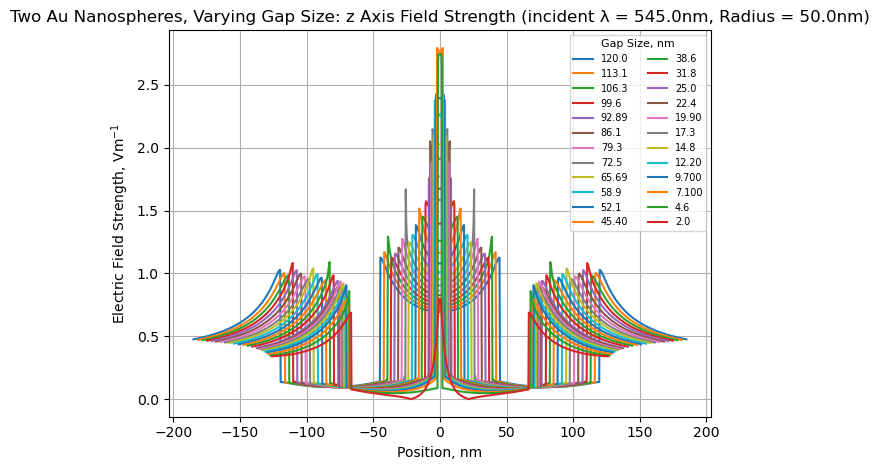

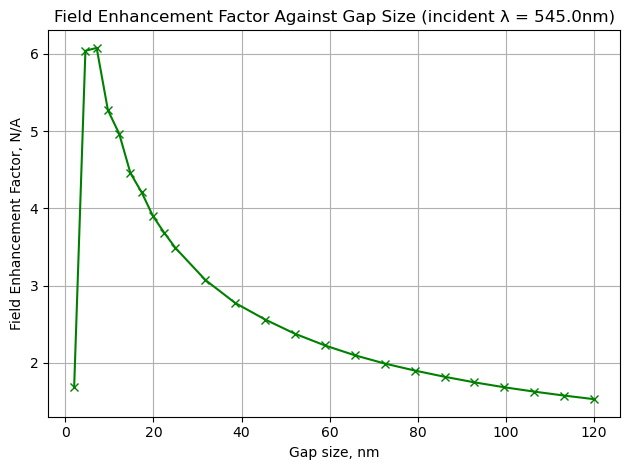

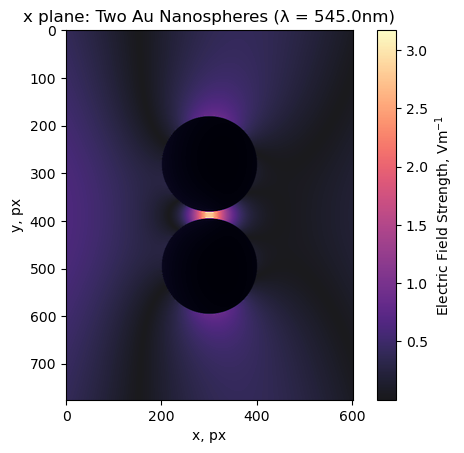

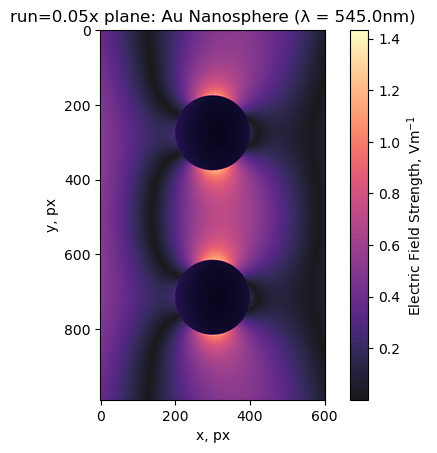

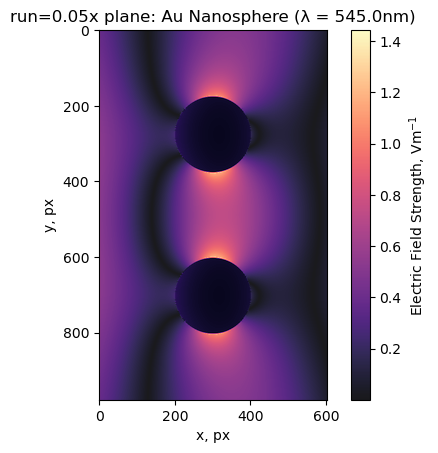

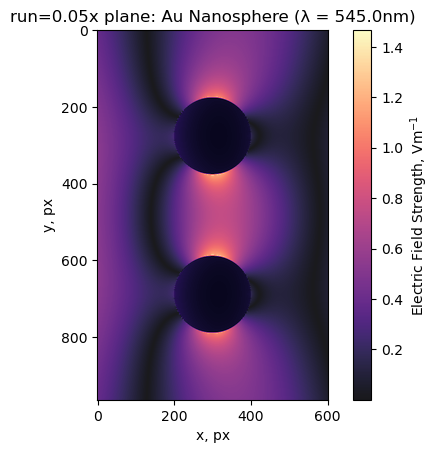

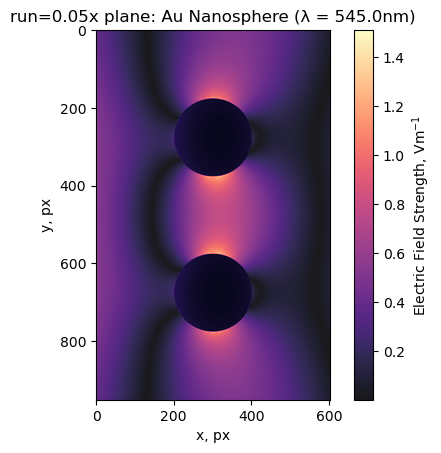

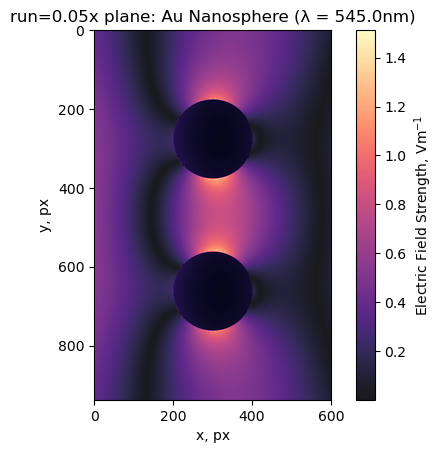

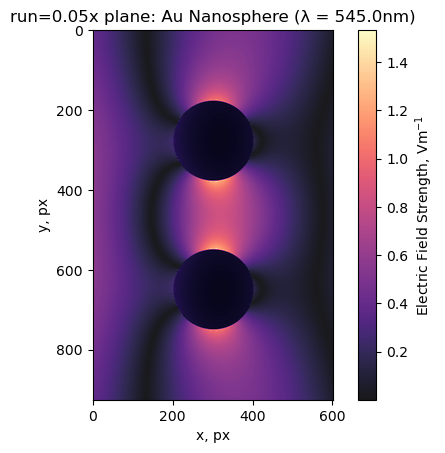

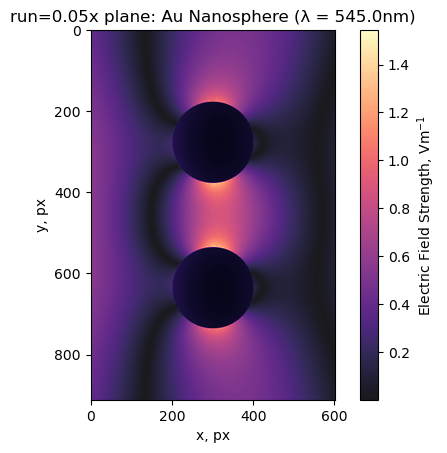

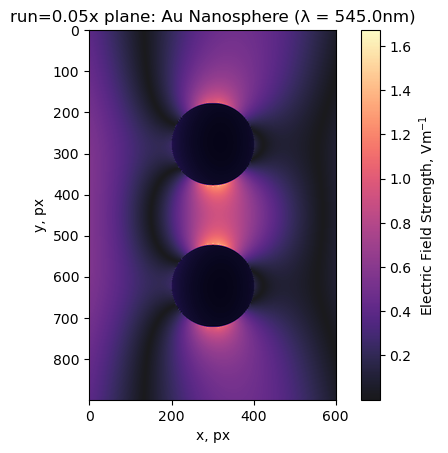

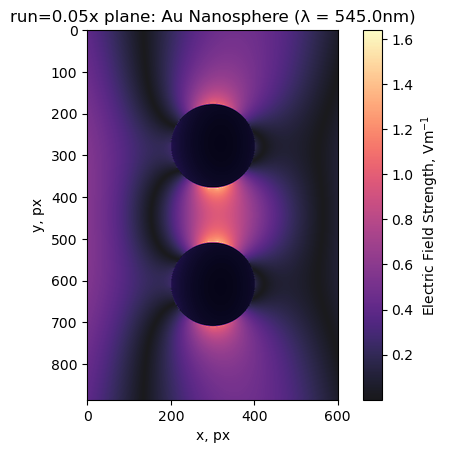

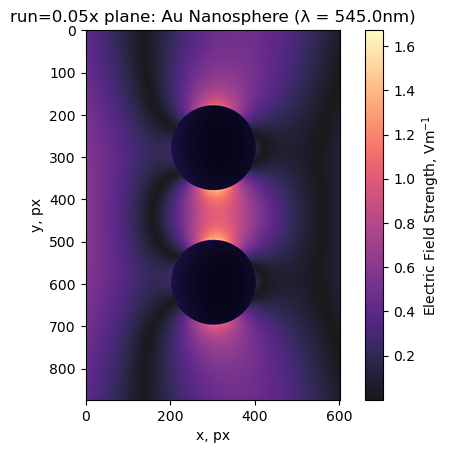

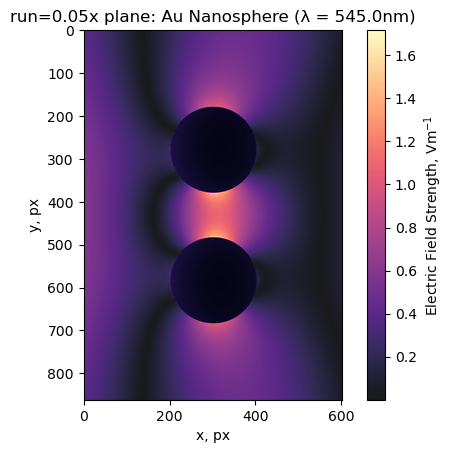

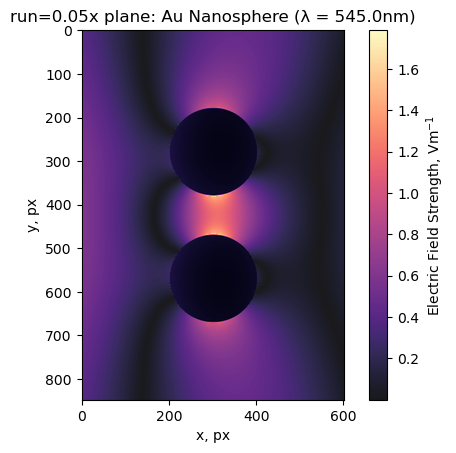

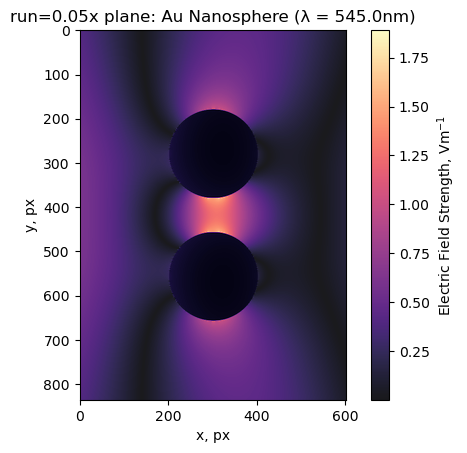

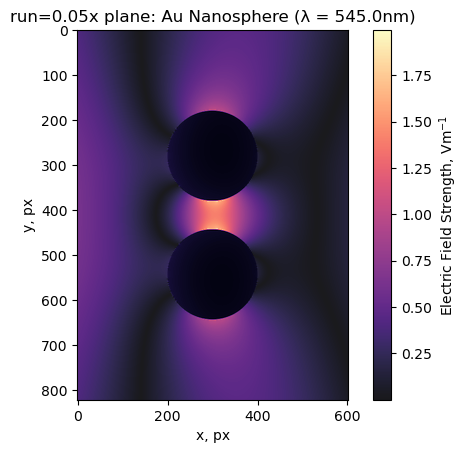

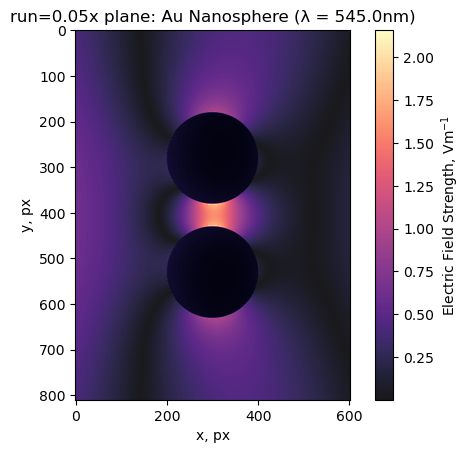

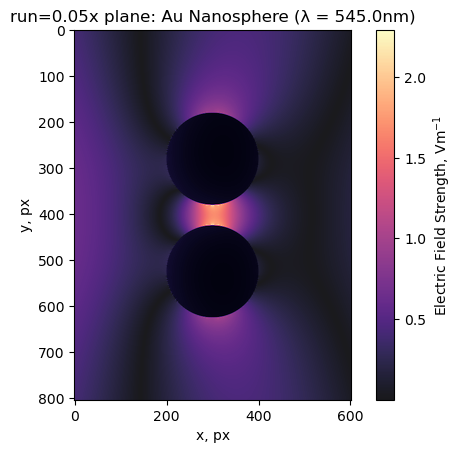

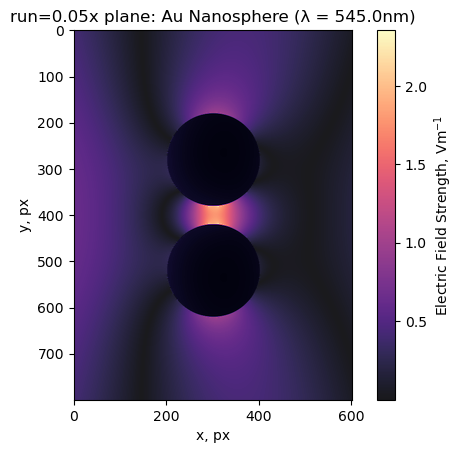

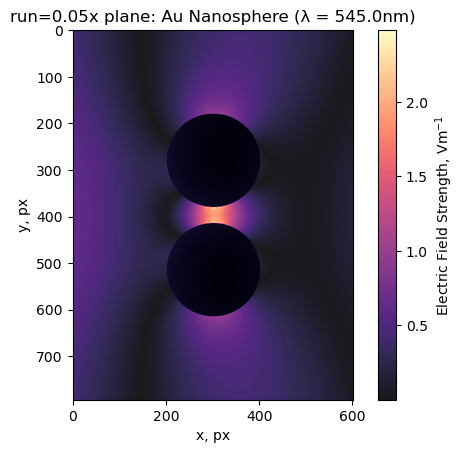

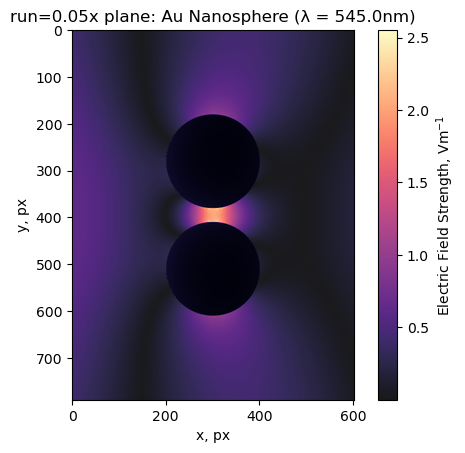

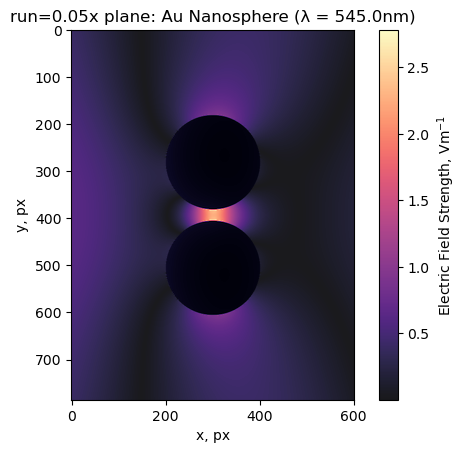

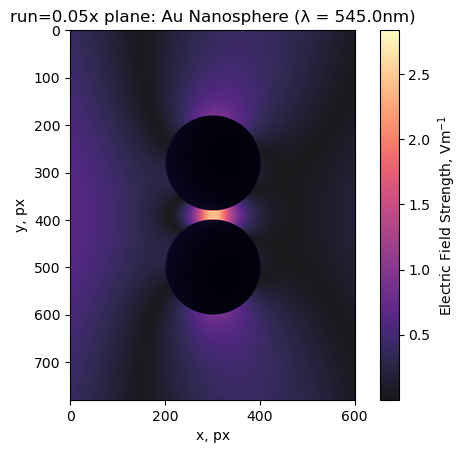

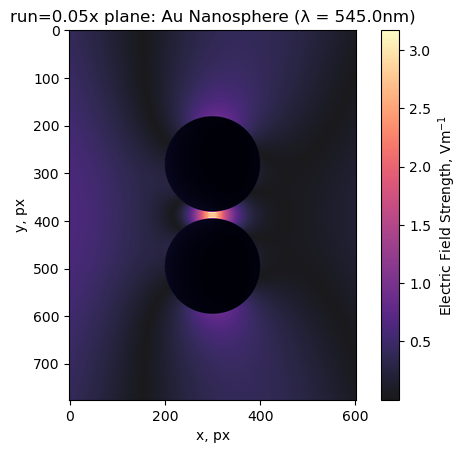

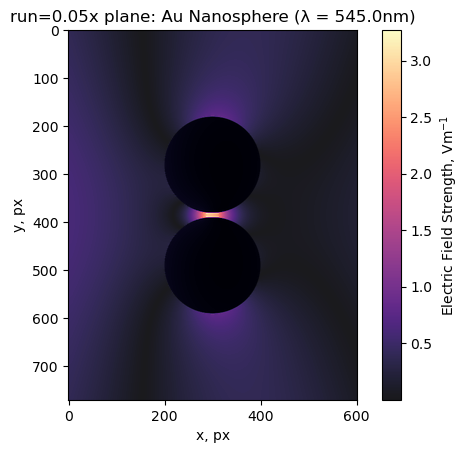

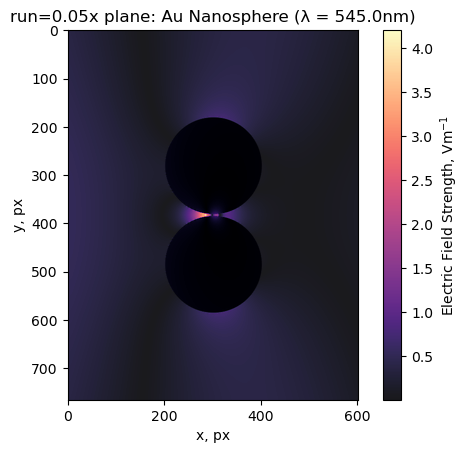

<Figure size 640x480 with 0 Axes>

In [5]:
print(inc_field_vals)

FEF_values = []

index = 0

plt.figure()
for run in E_data:
    
    E_strength = run
    
    pixels = len(E_data[index])
    range = (radii[index]*5+gaps[index])/2
    space_1D = 1E3*(np.linspace(-range, +range, pixels))
    #Also converting axis to position from pixels. 100 being the resolution value.

    FEF_values.append(np.interp(0.0, space_1D, E_strength) / inc_field_vals[index])

    #plt.figure()
    plt.plot(space_1D, E_strength, "-", label=f"{str(1E3*round(float(gaps[index]),4))[:5]}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Position, nm")
    plt.ylabel("Electric Field Strength, Vm$^{-1}$")
    plt.title(f"Two Au Nanospheres, Varying Gap Size: z Axis Field Strength (incident λ = {wvl*1E3}nm, Radius = {r*1E3}nm)")
    plt.legend(loc="upper right", title = "Gap Size, nm", fontsize = 7, title_fontsize= 8, ncol=2)
    plt.tight_layout()
    
    index+=1

plt.savefig(fname="Two Au Nanospheres, Varying Gap Size: z Axis Field Strength",
        dpi=150, 
        bbox_inches="tight")

plt.figure()
plt.plot(1E3*gaps, FEF_values, "x-g")
plt.grid(True, which="both", ls="-")
plt.xlabel("Gap size, nm")
plt.ylabel("Field Enhancement Factor, N/A")
plt.title(f"Field Enhancement Factor Against Gap Size (incident λ = {wvl*1E3}nm)")
plt.tight_layout()

plt.savefig(fname="Field Enhancement Factor Against Gap Size",
        dpi=150, 
        bbox_inches="tight")

print(1E3*gaps, FEF_values)
#Now just visualise the sphere with greatest enhancement.

index_largest_enhancement = np.argmax(FEF_values)

plt.figure()
plt.imshow(eps_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='binary')
plt.imshow(E_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)#, vmin=vmin)
colorbar = plt.colorbar()
colorbar.set_label("Electric Field Strength, Vm$^{-1}$")

plt.xlabel("x, px")
plt.ylabel("y, px")
plt.title(f"x plane: Two Au Nanospheres (λ = {1E3*wvl}nm)")
plt.savefig(fname="x plane: Two Au Nanospheres, greatest FEF, gap",
        dpi=150, 
        bbox_inches="tight")





for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]:
    plt.figure()
    plt.imshow(eps_data_vis[i].transpose(), interpolation='spline36', cmap='binary')
    plt.imshow(E_data_vis[i].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)#, vmin=vmin)
    colorbar = plt.colorbar()
    colorbar.set_label("Electric Field Strength, Vm$^{-1}$")
    
    plt.xlabel("x, px")
    plt.ylabel("y, px")
    plt.title(f"run={radii[i]}x plane: Au Nanosphere (λ = {1E3*wvl}nm)")
    plt.savefig(fname=f"r={int(i)}, x plane: Two Au Nanospheres, gap",
        dpi=150, 
        bbox_inches="tight")
    

In [3]:
# Varying Radius

wvl = 545E-3
gap = 50E-3

E_data = []  #Going to append all raw sim data arrays, to process and plot after the runs
inc_field_vals = []
E_data_vis = []
eps_data_vis = []


r_min =15E-3
r_max =180E-3

r_big = np.linspace(r_max, 105E-3, 6)
r_peak = np.linspace(105E-3, 90E-3, 10)
r_small = np.linspace(90E-3, r_min, 9)
radii = np.concatenate((r_big, r_peak[1:], r_small[1:]))

index = 1

for r in radii:
    print(f"##################### Run {index} Starting #######################")
    E_strength, inc_field_val, Ex_data, eps_data_x = get_sphere_coupling_enhancement(r, gap, wvl)
    
    E_data.append(E_strength)
    inc_field_vals.append(inc_field_val)
    E_data_vis.append(Ex_data)
    eps_data_vis.append(eps_data_x)

    index += 1


##################### Run 1 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00116491 s
Working in 2D dimensions.
Computational cell is 1.8 x 2.2104 x 0 with resolution 555.556
     sphere, center = (0,0.205,0)
          radius 0.18
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.205,0)
          radius 0.18
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.49347 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.1089/10.0 = 1.1% done in 4.0s, 364.3s to go
on time step 121 (time=0.1089), 0.0331528 s/step
Meep progress: 0.22319999999999998/10.0 = 2.2% done in 8.0s, 351.6s to go
on time step 248 (time=0.2232), 0.0316135 s/step
Meep progress: 0.3312/10.0 = 3.3% done in 12.0s, 351.3s to go
on time step 368 (time=0.3312), 0.0333758 s/step
Meep progress: 

run 0 finished at t = 10.0008 (11112 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000203133 s
Working in 2D dimensions.
Computational cell is 1.8 x 2.205 x 0 with resolution 22.2222
time for set_epsilon = 0.00535607 s
-----------
run 0 finished at t = 10.0125 (445 timesteps)


##################### Run 2 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00202489 s
Working in 2D dimensions.
Computational cell is 1.65 x 2.0295 x 0 with resolution 606.061
     sphere, center = (0,0.19,0)
          radius 0.165
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.19,0)
          radius 0.165
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 3.12872 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.086625/10.0 = 0.9% done in 4.0s, 457.9s to go
on time step 105 (time=0.086625), 0.0381116 s/step
Meep progress: 0.19717499999999996/10.0 = 2.0% done in 8.0s, 397.9s to go
on time step 239 (time=0.197175), 0.0298621 s/step
Meep progress: 0.29864999999999997/10.0 = 3.0% done in 12.0s, 390.4s to go
on time step 362 (time=0.29865), 0.0326195 s

run 0 finished at t = 10.000649999999998 (12122 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000127077 s
Working in 2D dimensions.
Computational cell is 1.65 x 2.02125 x 0 with resolution 24.2424
time for set_epsilon = 0.00478911 s
-----------
run 0 finished at t = 10.003124999999999 (485 timesteps)


##################### Run 3 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00132608 s
Working in 2D dimensions.
Computational cell is 1.5 x 1.8495 x 0 with resolution 666.667
     sphere, center = (0,0.175,0)
          radius 0.15
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.175,0)
          radius 0.15
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.48866 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.10349999999999998/10.0 = 1.0% done in 4.0s, 383.4s to go
on time step 138 (time=0.1035), 0.0290585 s/step
Meep progress: 0.22274999999999998/10.0 = 2.2% done in 8.0s, 351.9s to go
on time step 297 (time=0.22275), 0.0251996 s/step
Meep progress: 0.34424999999999994/10.0 = 3.4% done in 12.0s, 337.3s to go
on time step 459 (time=0.34425), 0.02

run 0 finished at t = 10.000499999999999 (13334 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000123024 s
Working in 2D dimensions.
Computational cell is 1.5 x 1.8375 x 0 with resolution 26.6667
time for set_epsilon = 0.004426 s
-----------
run 0 finished at t = 10.0125 (534 timesteps)
##################### Run 4 Starting #######################
-----------
Initializing structure...


time for choose_chunkdivision = 0.00131202 s
Working in 2D dimensions.
Computational cell is 1.35 x 1.66995 x 0 with resolution 740.741
     sphere, center = (0,0.16,0)
          radius 0.135
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.16,0)
          radius 0.135
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.37834 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.087075/10.0 = 0.9% done in 4.0s, 457.0s to go
on time step 129 (time=0.087075), 0.031117 s/step
Meep progress: 0.182925/10.0 = 1.8% done in 8.0s, 431.0s to go
on time step 271 (time=0.182925), 0.0282842 s/step
Meep progress: 0.2781/10.0 = 2.8% done in 12.0s, 420.8s to go
on time step 412 (time=0.2781), 0.0284121 s/step
Meep progress: 0.373275/10.0 = 3.7% done in 16.1s, 414.2s to go
on time step 553 (time=0.373275), 0.0285317 s/step
Mee

run 0 finished at t = 10.000125 (14815 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 8.89301e-05 s
Working in 2D dimensions.
Computational cell is 1.35 x 1.65375 x 0 with resolution 29.6296
time for set_epsilon = 0.00254011 s
-----------


run 0 finished at t = 10.006875 (593 timesteps)
##################### Run 5 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.001158 s
Working in 2D dimensions.
Computational cell is 1.2 x 1.4904 x 0 with resolution 833.333
     sphere, center = (0,0.145,0)
          radius 0.12
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.145,0)
          radius 0.12
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.61969 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.08579999999999999/10.0 = 0.9% done in 4.0s, 462.8s to go
on time step 143 (time=0.0858), 0.0280071 s/step
Meep progress: 0.17579999999999998/10.0 = 1.8% done in 8.0s, 447.4s to go
on time step 293 (time=0.1758), 0.0266732 s/step
Meep progress: 0.2658/10.0 = 2.7% done in 12.0s, 440.3s to go
on ti

run 0 finished at t = 10.0002 (16667 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000101089 s
Working in 2D dimensions.
Computational cell is 1.2 x 1.5 x 0 with resolution 33.3333
time for set_epsilon = 0.0032661 s
-----------
run 0 finished at t = 10.004999999999999 (667 timesteps)


##################### Run 6 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00110698 s
Working in 2D dimensions.
Computational cell is 1.05 x 1.3104 x 0 with resolution 952.381
     sphere, center = (0,0.13,0)
          radius 0.105
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.13,0)
          radius 0.105
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.3279 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.0798/10.0 = 0.8% done in 4.0s, 499.6s to go
on time step 152 (time=0.0798), 0.0264388 s/step
Meep progress: 0.164325/10.0 = 1.6% done in 8.0s, 480.1s to go
on time step 313 (time=0.164325), 0.0248525 s/step
Meep progress: 0.24937499999999999/10.0 = 2.5% done in 12.0s, 470.2s to go
on time step 475 (time=0.249375), 0.0247247 s/step
Meep prog

run 0 finished at t = 10.0002 (19048 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.00011611 s
Working in 2D dimensions.
Computational cell is 1.05 x 1.3125 x 0 with resolution 38.0952
time for set_epsilon = 0.00515199 s
-----------
run 0 finished at t = 10.001249999999999 (762 timesteps)


##################### Run 7 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00113797 s
Working in 2D dimensions.
Computational cell is 1.03333 x 1.2896 x 0 with resolution 967.742
     sphere, center = (0,0.128333,0)
          radius 0.103333
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.128333,0)
          radius 0.103333
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.38005 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.06613333333333334/10.0 = 0.7% done in 4.0s, 603.7s to go
on time step 128 (time=0.0661333), 0.0314004 s/step
Meep progress: 0.1426/10.0 = 1.4% done in 8.0s, 555.9s to go
on time step 276 (time=0.1426), 0.0271737 s/step
Meep progress: 0.21235/10.0 = 2.1% done in 12.1s, 555.5s to go
on time step 411 (time=0.21235), 0.0297056

run 0 finished at t = 10.000083333333334 (19355 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 7.70092e-05 s
Working in 2D dimensions.
Computational cell is 1.03333 x 1.29167 x 0 with resolution 38.7097
time for set_epsilon = 0.00361896 s
-----------


run 0 finished at t = 10.010416666666666 (775 timesteps)
##################### Run 8 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000777006 s
Working in 2D dimensions.
Computational cell is 1.01667 x 1.26982 x 0 with resolution 983.607
     sphere, center = (0,0.126667,0)
          radius 0.101667
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.126667,0)
          radius 0.101667
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.76383 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.07421666666666667/10.0 = 0.7% done in 4.0s, 536.3s to go
on time step 146 (time=0.0742167), 0.0274694 s/step
Meep progress: 0.15046666666666667/10.0 = 1.5% done in 8.0s, 525.4s to go
on time step 296 (time=0.150467), 0.0267651 s/step
Meep progress: 0.22976666666666

run 0 finished at t = 10.000441666666665 (19673 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000102997 s
Working in 2D dimensions.
Computational cell is 1.01667 x 1.27083 x 0 with resolution 39.3443
time for set_epsilon = 0.0036459 s
-----------
run 0 finished at t = 10.001458333333334 (787 timesteps)


##################### Run 9 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00116801 s
Working in 2D dimensions.
Computational cell is 1 x 1.25 x 0 with resolution 1000
     sphere, center = (0,0.125,0)
          radius 0.1
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.125,0)
          radius 0.1
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.38326 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.061499999999999985/10.0 = 0.6% done in 4.0s, 646.6s to go
on time step 123 (time=0.0615), 0.0325342 s/step
Meep progress: 0.12849999999999998/10.0 = 1.3% done in 8.0s, 614.7s to go
on time step 257 (time=0.1285), 0.0298512 s/step
Meep progress: 0.19449999999999995/10.0 = 1.9% done in 12.0s, 606.3s to go
on time step 389 (time=0.1945), 0.0304737 s/st

run 0 finished at t = 9.999999999999998 (20000 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 9.39369e-05 s
Working in 2D dimensions.
Computational cell is 1 x 1.25 x 0 with resolution 40
time for set_epsilon = 0.00286579 s
-----------


run 0 finished at t = 10.0 (800 timesteps)
##################### Run 10 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.001266 s
Working in 2D dimensions.
Computational cell is 0.983333 x 1.23015 x 0 with resolution 1016.95
     sphere, center = (0,0.123333,0)
          radius 0.0983333
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.123333,0)
          radius 0.0983333
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.22451 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.0649/10.0 = 0.6% done in 4.0s, 613.9s to go
on time step 132 (time=0.0649), 0.0303806 s/step
Meep progress: 0.13865/10.0 = 1.4% done in 8.0s, 570.0s to go
on time step 282 (time=0.13865), 0.0266918 s/step
Meep progress: 0.21239999999999998/10.0 = 2.1% done in 12.0s, 554.1s to g

run 0 finished at t = 10.000008333333332 (20339 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000123024 s
Working in 2D dimensions.
Computational cell is 0.983333 x 1.22917 x 0 with resolution 40.678
time for set_epsilon = 0.00415087 s
-----------
run 0 finished at t = 10.005416666666665 (814 timesteps)


##################### Run 11 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00131011 s
Working in 2D dimensions.
Computational cell is 0.966667 x 1.21027 x 0 with resolution 1034.48
     sphere, center = (0,0.121667,0)
          radius 0.0966667
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.121667,0)
          radius 0.0966667
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.29729 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.06476666666666665/10.0 = 0.6% done in 4.0s, 617.4s to go
on time step 134 (time=0.0647667), 0.030038 s/step
Meep progress: 0.13291666666666666/10.0 = 1.3% done in 8.0s, 597.3s to go
on time step 275 (time=0.132917), 0.0285097 s/step
Meep progress: 0.1991333333333333/10.0 = 2.0% done in 12.1s, 594.1s to go
on time step

run 0 finished at t = 10.000166666666665 (20690 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000152826 s
Working in 2D dimensions.
Computational cell is 0.966667 x 1.20833 x 0 with resolution 41.3793
time for set_epsilon = 0.00420189 s
-----------
run 0 finished at t = 10.004999999999999 (828 timesteps)


##################### Run 12 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00123191 s
Working in 2D dimensions.
Computational cell is 0.95 x 1.19035 x 0 with resolution 1052.63
     sphere, center = (0,0.12,0)
          radius 0.095
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.12,0)
          radius 0.095
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.32445 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.06602500000000001/10.0 = 0.7% done in 4.0s, 603.6s to go
on time step 139 (time=0.066025), 0.0288615 s/step
Meep progress: 0.13822500000000001/10.0 = 1.4% done in 8.0s, 571.7s to go
on time step 291 (time=0.138225), 0.0263233 s/step
Meep progress: 0.20662500000000003/10.0 = 2.1% done in 12.0s, 570.3s to go
on time step 435 (time=0.206625

run 0 finished at t = 10.000175 (21053 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 9.89437e-05 s
Working in 2D dimensions.
Computational cell is 0.95 x 1.1875 x 0 with resolution 42.1053
time for set_epsilon = 0.00408792 s
-----------
run 0 finished at t = 10.010625 (843 timesteps)


##################### Run 13 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00155997 s
Working in 2D dimensions.
Computational cell is 0.933333 x 1.1704 x 0 with resolution 1071.43
     sphere, center = (0,0.118333,0)
          radius 0.0933333
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.118333,0)
          radius 0.0933333
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.17077 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.06439999999999999/10.0 = 0.6% done in 4.0s, 618.8s to go
on time step 138 (time=0.0644), 0.0290643 s/step
Meep progress: 0.13999999999999999/10.0 = 1.4% done in 8.0s, 565.0s to go
on time step 300 (time=0.14), 0.0247569 s/step
Meep progress: 0.21886666666666663/10.0 = 2.2% done in 12.0s, 537.5s to go
on time step 469 (

run 0 finished at t = 10.0002 (21429 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000109911 s
Working in 2D dimensions.
Computational cell is 0.933333 x 1.16667 x 0 with resolution 42.8571
time for set_epsilon = 0.00342798 s
-----------
run 0 finished at t = 10.01 (858 timesteps)


##################### Run 14 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.0012579 s
Working in 2D dimensions.
Computational cell is 0.916667 x 1.15042 x 0 with resolution 1090.91
     sphere, center = (0,0.116667,0)
          radius 0.0916667
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.116667,0)
          radius 0.0916667
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.09886 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.06279166666666666/10.0 = 0.6% done in 4.0s, 634.7s to go
on time step 137 (time=0.0627917), 0.0292751 s/step
Meep progress: 0.12879166666666667/10.0 = 1.3% done in 8.0s, 616.2s to go
on time step 281 (time=0.128792), 0.0279786 s/step
Meep progress: 0.19983333333333334/10.0 = 2.0% done in 12.1s, 591.4s to go
on time ste

run 0 finished at t = 10.000375 (21819 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 7.70092e-05 s
Working in 2D dimensions.
Computational cell is 0.916667 x 1.14583 x 0 with resolution 43.6364
time for set_epsilon = 0.0032382 s
-----------


run 0 finished at t = 10.003124999999999 (873 timesteps)
##################### Run 15 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000932932 s
Working in 2D dimensions.
Computational cell is 0.9 x 1.1304 x 0 with resolution 1111.11
     sphere, center = (0,0.115,0)
          radius 0.09
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.115,0)
          radius 0.09
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.6579 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.0738/10.0 = 0.7% done in 4.0s, 540.4s to go
on time step 164 (time=0.0738), 0.0245006 s/step
Meep progress: 0.14085/10.0 = 1.4% done in 8.0s, 562.8s to go
on time step 313 (time=0.14085), 0.0269882 s/step
Meep progress: 0.20429999999999998/10.0 = 2.0% done in 12.0s, 577.6s to go
on t

run 0 finished at t = 10.00035 (22223 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000103951 s
Working in 2D dimensions.
Computational cell is 0.9 x 1.125 x 0 with resolution 44.4444
time for set_epsilon = 0.00347018 s
-----------
run 0 finished at t = 10.001249999999999 (889 timesteps)


##################### Run 16 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00114107 s
Working in 2D dimensions.
Computational cell is 0.80625 x 1.01749 x 0 with resolution 1240.31
     sphere, center = (0,0.105625,0)
          radius 0.080625
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.105625,0)
          radius 0.080625
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.28515 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.058453125/10.0 = 0.6% done in 4.0s, 682.4s to go
on time step 145 (time=0.0584531), 0.0276739 s/step
Meep progress: 0.124565625/10.0 = 1.2% done in 8.0s, 636.5s to go
on time step 309 (time=0.124566), 0.0244834 s/step
Meep progress: 0.192290625/10.0 = 1.9% done in 12.0s, 614.1s to go
on time step 477 (time=0.192291), 0.0

run 0 finished at t = 10.000321875 (24807 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000111103 s
Working in 2D dimensions.
Computational cell is 0.80625 x 1.00781 x 0 with resolution 49.6124
time for set_epsilon = 0.00445008 s
-----------
run 0 finished at t = 10.007578125 (993 timesteps)


##################### Run 17 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00115108 s
Working in 2D dimensions.
Computational cell is 0.7125 x 0.904875 x 0 with resolution 1403.51
     sphere, center = (0,0.09625,0)
          radius 0.07125
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.09625,0)
          radius 0.07125
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.23554 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.04916249999999999/10.0 = 0.5% done in 4.0s, 811.3s to go
on time step 138 (time=0.0491625), 0.0290457 s/step
Meep progress: 0.10188749999999999/10.0 = 1.0% done in 8.0s, 778.7s to go
on time step 286 (time=0.101887), 0.0270668 s/step
Meep progress: 0.15674999999999997/10.0 = 1.6% done in 12.0s, 754.6s to go
on time step 440 

run 0 finished at t = 10.000293749999999 (28071 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 9.20296e-05 s
Working in 2D dimensions.
Computational cell is 0.7125 x 0.908437 x 0 with resolution 56.1404
time for set_epsilon = 0.00323701 s
-----------


run 0 finished at t = 10.001718749999998 (1123 timesteps)
##################### Run 18 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.000789165 s
Working in 2D dimensions.
Computational cell is 0.61875 x 0.792619 x 0 with resolution 1616.16
     sphere, center = (0,0.086875,0)
          radius 0.061875
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.086875,0)
          radius 0.061875
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 1.59178 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.049190625/10.0 = 0.5% done in 4.0s, 809.4s to go
on time step 159 (time=0.0491906), 0.0251647 s/step
Meep progress: 0.099309375/10.0 = 1.0% done in 8.0s, 798.1s to go
on time step 321 (time=0.0993094), 0.0247159 s/step
Meep progress: 0.14942812500000002/10.0 = 1

run 0 finished at t = 10.0002375 (32324 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 9.89437e-05 s
Working in 2D dimensions.
Computational cell is 0.61875 x 0.788906 x 0 with resolution 64.6465
time for set_epsilon = 0.00325799 s
-----------
run 0 finished at t = 10.000546875 (1293 timesteps)


##################### Run 19 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00130105 s
Working in 2D dimensions.
Computational cell is 0.525 x 0.679875 x 0 with resolution 1904.76
     sphere, center = (0,0.0775,0)
          radius 0.0525
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.0775,0)
          radius 0.0525
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.0471 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.0349125/10.0 = 0.3% done in 4.0s, 1146.6s to go
on time step 133 (time=0.0349125), 0.0302057 s/step
Meep progress: 0.0732375/10.0 = 0.7% done in 8.0s, 1087.9s to go
on time step 279 (time=0.0732375), 0.0274535 s/step
Meep progress: 0.11523749999999999/10.0 = 1.2% done in 12.0s, 1032.6s to go
on time step 439 (time=0.115237), 0.025

run 0 finished at t = 10.0002 (38096 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000110149 s
Working in 2D dimensions.
Computational cell is 0.525 x 0.6825 x 0 with resolution 76.1905
time for set_epsilon = 0.00391197 s
-----------


run 0 finished at t = 10.001249999999999 (1524 timesteps)
##################### Run 20 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00119495 s
Working in 2D dimensions.
Computational cell is 0.43125 x 0.567525 x 0 with resolution 2318.84
     sphere, center = (0,0.068125,0)
          radius 0.043125
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.068125,0)
          radius 0.043125
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.29269 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.028246875/10.0 = 0.3% done in 4.0s, 1413.3s to go
on time step 131 (time=0.0282469), 0.0305625 s/step
Meep progress: 0.05908125/10.0 = 0.6% done in 8.0s, 1348.2s to go
on time step 274 (time=0.0590813), 0.0280304 s/step
Meep progress: 0.089053125/10.0 = 0.9% done

Meep progress: 9.99853125/10.0 = 100.0% done in 1340.5s, 0.2s to go
run 0 finished at t = 10.000040625 (46377 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000132084 s
Working in 2D dimensions.
Computational cell is 0.43125 x 0.571406 x 0 with resolution 92.7536
time for set_epsilon = 0.003582 s
-----------


run 0 finished at t = 10.004999999999999 (1856 timesteps)
##################### Run 21 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00113201 s
Working in 2D dimensions.
Computational cell is 0.3375 x 0.45495 x 0 with resolution 2962.96
     sphere, center = (0,0.05875,0)
          radius 0.03375
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.05875,0)
          radius 0.03375
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.36049 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.02311875/10.0 = 0.2% done in 4.0s, 1728.3s to go
on time step 137 (time=0.0231188), 0.0292344 s/step
Meep progress: 0.048600000000000004/10.0 = 0.5% done in 8.0s, 1641.5s to go
on time step 288 (time=0.0486), 0.0265624 s/step
Meep progress: 0.07526250000000001/10.0 = 0

Meep progress: 9.9991125/10.0 = 100.0% done in 1730.4s, 0.2s to go
run 0 finished at t = 10.000125 (59260 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 9.20296e-05 s
Working in 2D dimensions.
Computational cell is 0.3375 x 0.455625 x 0 with resolution 118.519
time for set_epsilon = 0.00321412 s
-----------


run 0 finished at t = 10.002656250000001 (2371 timesteps)
##################### Run 22 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.00099206 s
Working in 2D dimensions.
Computational cell is 0.24375 x 0.342469 x 0 with resolution 4102.56
     sphere, center = (0,0.049375,0)
          radius 0.024375
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.049375,0)
          radius 0.024375
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.27528 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.016453124999999996/10.0 = 0.2% done in 4.0s, 2430.4s to go
on time step 135 (time=0.0164531), 0.0296707 s/step
Meep progress: 0.03522187499999999/10.0 = 0.4% done in 8.0s, 2270.3s to go
on time step 289 (time=0.0352219), 0.0260959 s/step
Meep progress: 0.05411249

run 0 finished at t = 10.000087499999998 (82052 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000133991 s
Working in 2D dimensions.
Computational cell is 0.24375 x 0.34125 x 0 with resolution 164.103
time for set_epsilon = 0.00359797 s
-----------


run 0 finished at t = 10.002890624999997 (3283 timesteps)
##################### Run 23 Starting #######################
-----------
Initializing structure...
time for choose_chunkdivision = 0.0012362 s
Working in 2D dimensions.
Computational cell is 0.15 x 0.22995 x 0 with resolution 6666.67
     sphere, center = (0,0.04,0)
          radius 0.015
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
     sphere, center = (0,-0.04,0)
          radius 0.015
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.42154 s
lorentzian susceptibility: frequency=-0.524219, gamma=0.0182963
lorentzian susceptibility: frequency=3.65545, gamma=2.74085
-----------
Meep progress: 0.008249999999999999/10.0 = 0.1% done in 4.0s, 4847.3s to go
on time step 110 (time=0.00825), 0.0363864 s/step
Meep progress: 0.018074999999999997/10.0 = 0.2% done in 8.0s, 4434.6s to go
on time step 241 (time=0.018075), 0.030738 s/step
Meep progress: 0.02865/10.0 = 0.3% done in 12.1

Meep progress: 9.999825/10.0 = 100.0% done in 3850.1s, 0.1s to go
run 0 finished at t = 10.00005 (133334 timesteps)
$$$$$$$$$$$$$$$$ Calculating Incident Field Strength $$$$$$$$$$$$$$$$$$$$
-----------
Initializing structure...
time for choose_chunkdivision = 0.000104904 s
Working in 2D dimensions.
Computational cell is 0.15 x 0.22875 x 0 with resolution 266.667
time for set_epsilon = 0.00274396 s
-----------
run 0 finished at t = 10.001249999999999 (5334 timesteps)


[0.3179364046633113, 0.433213117068193, 0.46029067886481845, 0.3654422003712965, 0.17281623621596454, 0.054655845884617235, 0.13277436631861425, 0.1114028795749621, 0.1308536743857702, 0.1864084471986996, 0.21011681708068344, 0.2626391832764767, 0.2832746069742499, 0.27475377686546054, 0.2893223063787219, 0.4208878183824528, 0.4727742911929582, 0.49445341740053944, 0.46650847666462614, 0.37866866146120814, 0.27413580504630924, 0.13826915402910056, 0.015331678178498977]
[180.         165.         150.         135.         120.
 105.         103.33333333 101.66666667 100.          98.33333333
  96.66666667  95.          93.33333333  91.66666667  90.
  80.625       71.25        61.875       52.5         43.125
  33.75        24.375       15.        ] [1.321564006297677, 0.8900585365768368, 1.6382142242301625, 1.9679247757657785, 3.541746601879932, 11.415579188690755, 4.728023496804085, 5.474782911656747, 4.648739485896114, 3.178041646502953, 2.7057667847566114, 2.081926553317877, 1.791110

/tmp/ipykernel_18250/3341033047.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


IndexError: list index out of range

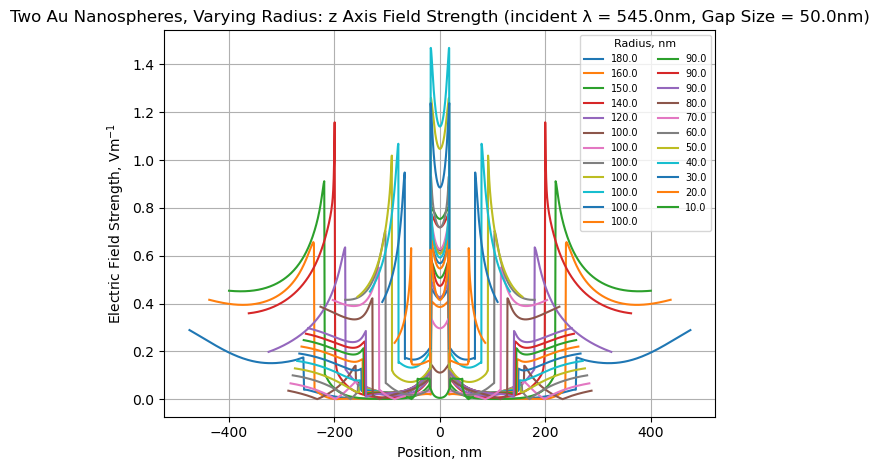

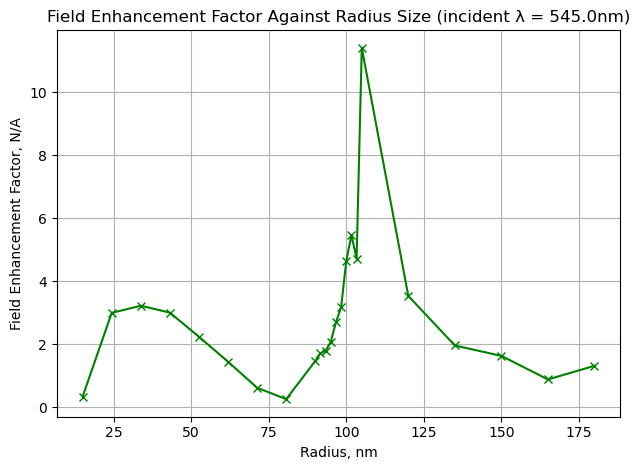

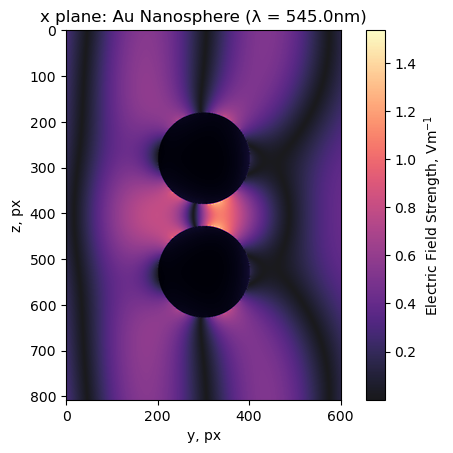

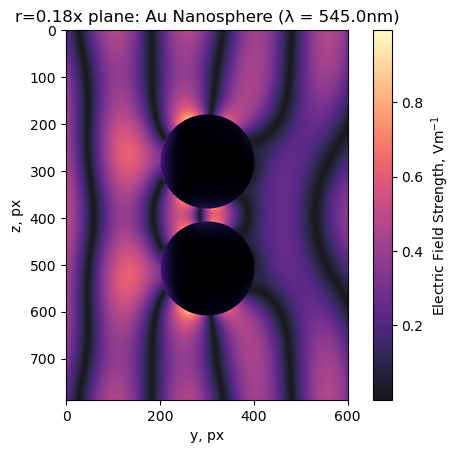

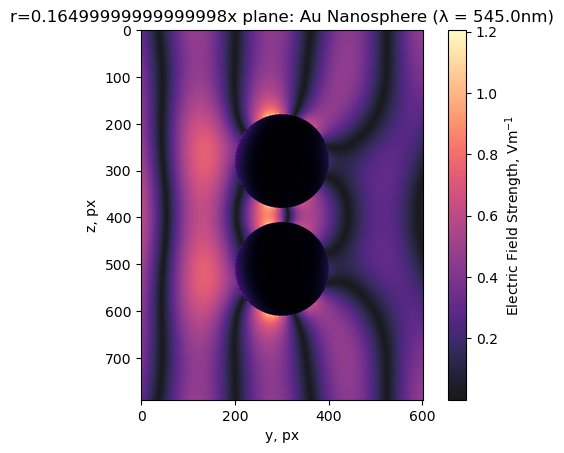

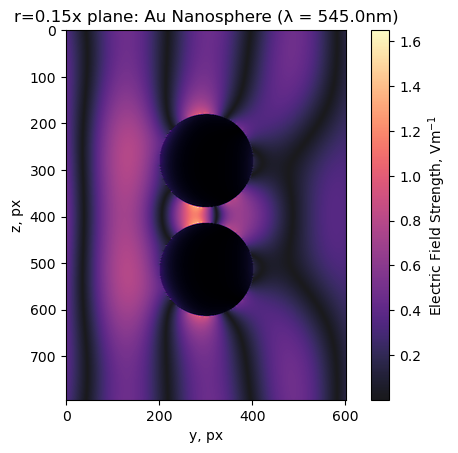

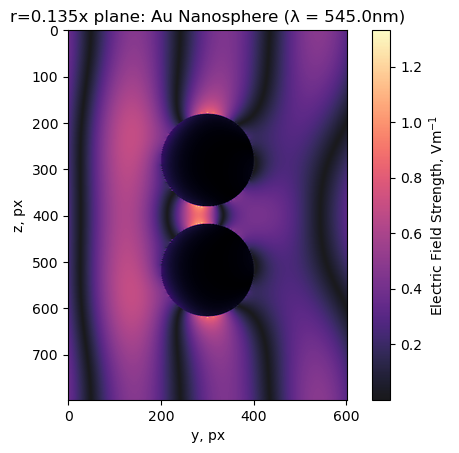

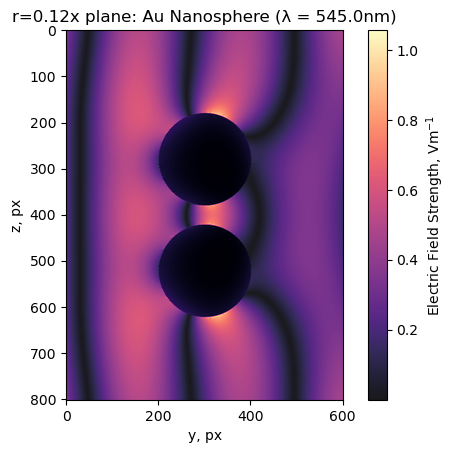

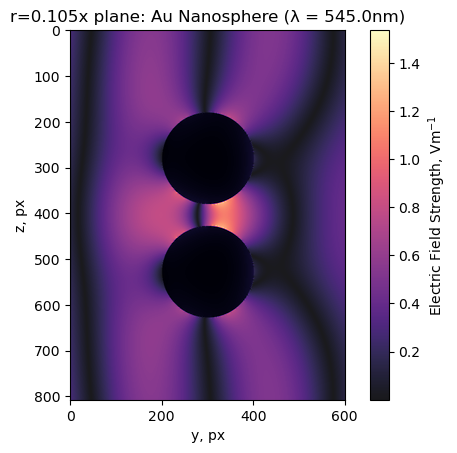

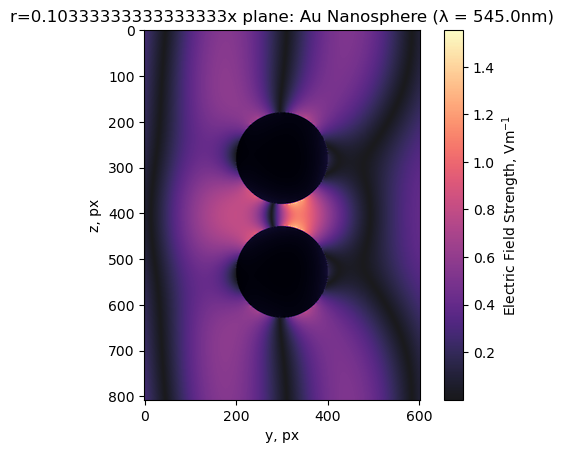

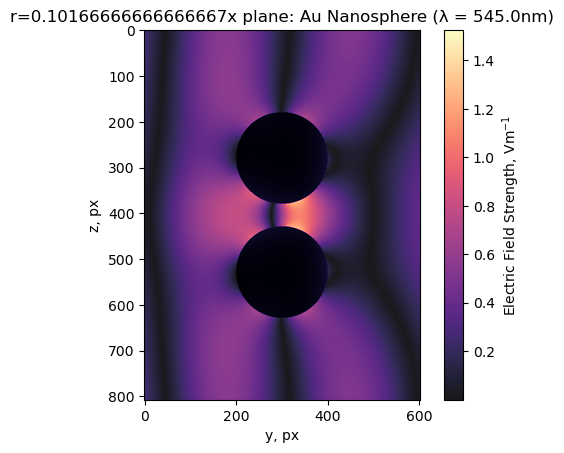

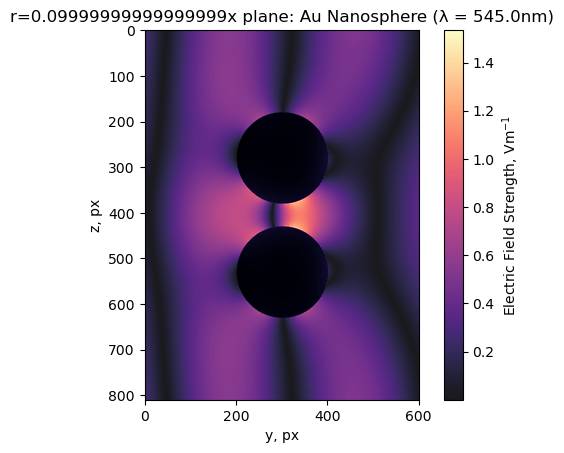

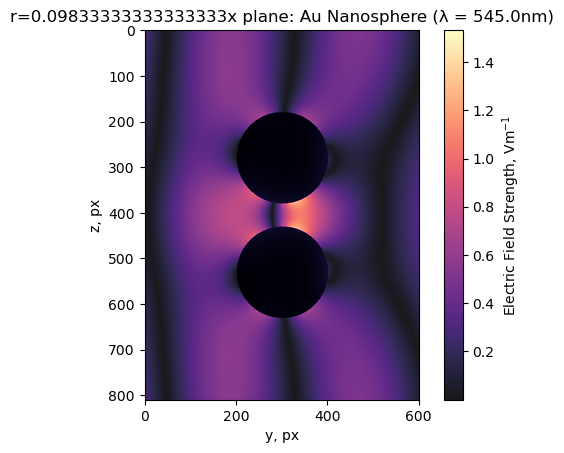

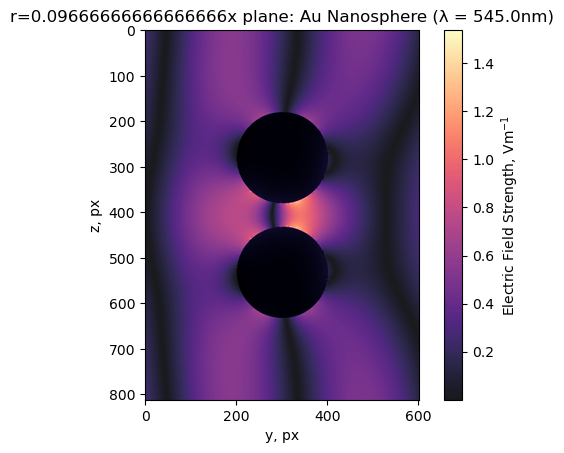

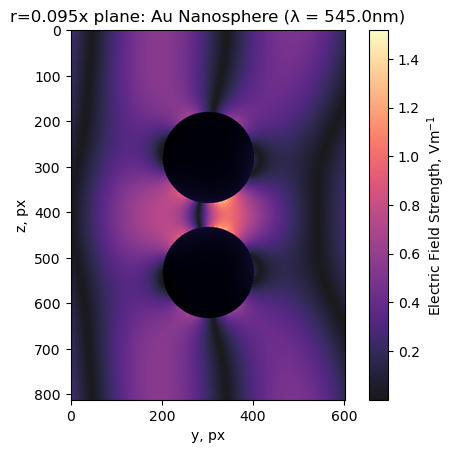

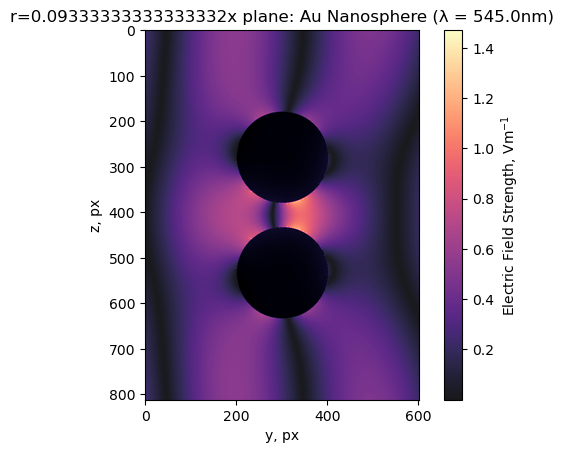

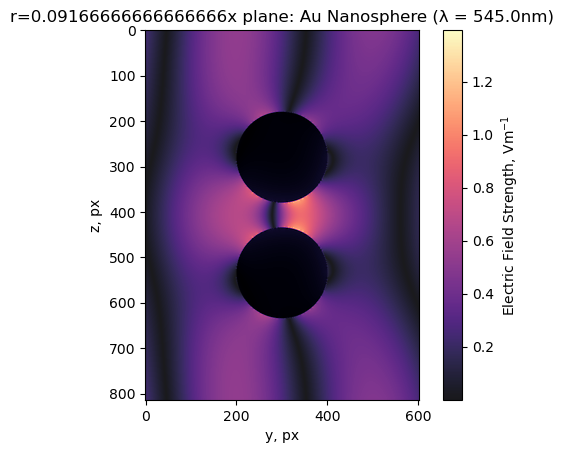

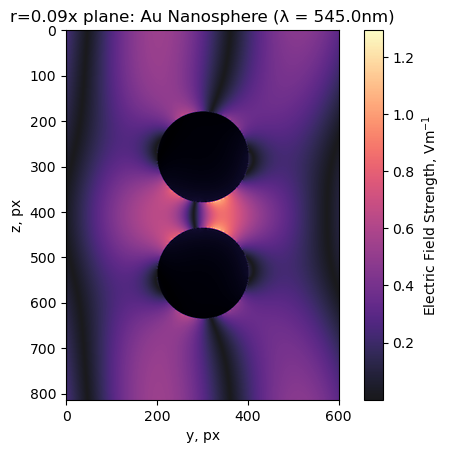

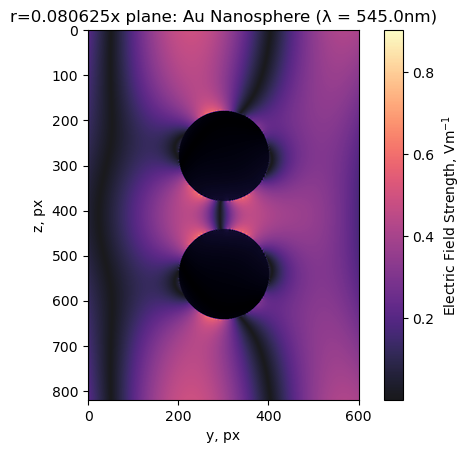

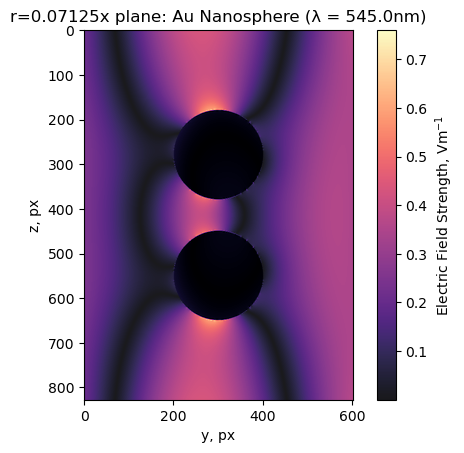

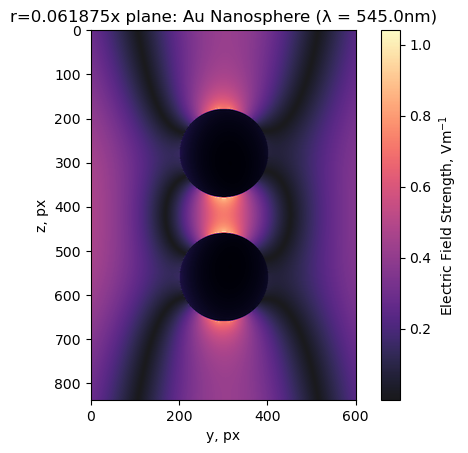

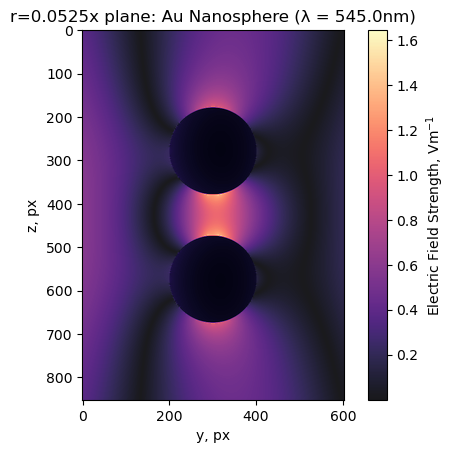

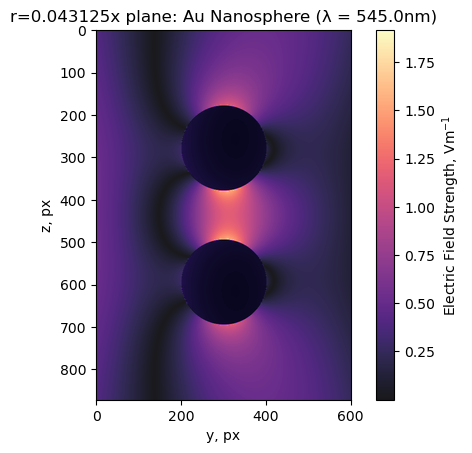

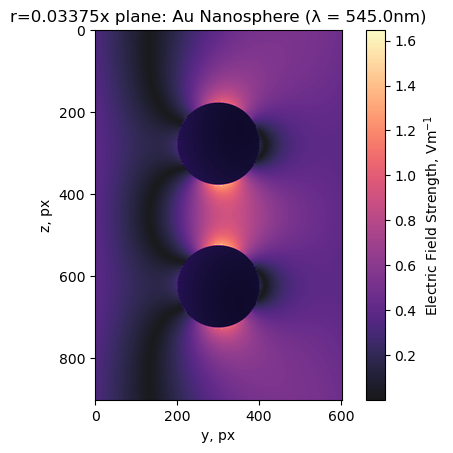

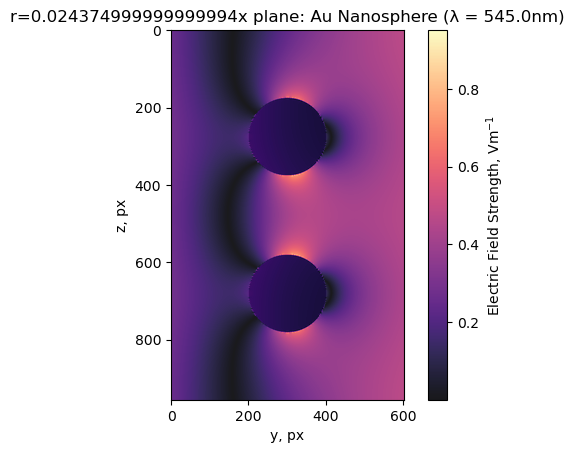

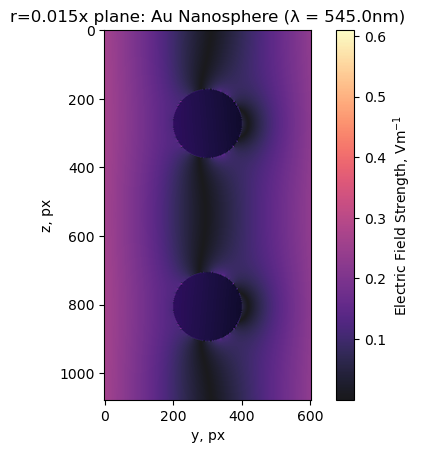

<Figure size 640x480 with 0 Axes>

In [5]:
FEF_values = []
print(inc_field_vals)

index = 0

plt.figure()
for run in E_data:
    
    E_strength = run
    
    pixels = len(E_data[index])
    range = (radii[index]*5+gap)/2
    space_1D = 1E3*(np.linspace(-range, +range, pixels))
    #Also converting axis to position from pixels. 100 being the resolution value.

    FEF_values.append(np.interp(0.0, space_1D, E_strength) / inc_field_vals[index])

    #plt.figure()
    plt.plot(space_1D, E_strength, "-", label=f"{str(1E3*round(float(radii[index]),2))[:5]}")
    plt.grid(True, which="both", ls="-")
    plt.xlabel("Position, nm")
    plt.ylabel("Electric Field Strength, Vm$^{-1}$")
    plt.title(f"Two Au Nanospheres, Varying Radius: z Axis Field Strength (incident λ = {wvl*1E3}nm, Gap Size = {gap*1E3}nm)")
    plt.legend(loc="upper right", title = "Radius, nm", fontsize = 7, title_fontsize= 8, ncol=2)
    plt.tight_layout()
    #plt.show()
    
    index+=1

plt.savefig(fname="Two Au Nanospheres, Varying Radius: z Axis Field Strength",
        dpi=150, 
        bbox_inches="tight")

plt.figure()
plt.plot(1E3*radii, FEF_values, "x-g")
plt.grid(True, which="both", ls="-")
plt.xlabel("Radius, nm")
plt.ylabel("Field Enhancement Factor, N/A")
plt.title(f"Field Enhancement Factor Against Radius Size (incident λ = {wvl*1E3}nm)")
plt.tight_layout()

plt.savefig(fname="Field Enhancement Factor Against Radius Size",
        dpi=150, 
        bbox_inches="tight")

print(1E3*radii, FEF_values)

#Now just visualise the sphere with greatest enhancement.

index_largest_enhancement = np.argmax(FEF_values)

plt.figure()
plt.imshow(eps_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='binary')
plt.imshow(E_data_vis[index_largest_enhancement].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)#, vmin=vmin)
colorbar = plt.colorbar()
colorbar.set_label("Electric Field Strength, Vm$^{-1}$")

plt.xlabel("y, px")
plt.ylabel("z, px")
plt.title(f"x plane: Au Nanosphere (λ = {1E3*wvl}nm)")
plt.savefig(fname=f"run=x plane: Two Au Nanospheres, greatest FEF, rad",
    dpi=150, 
    bbox_inches="tight")


for index in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]:
    plt.figure()
    plt.imshow(eps_data_vis[index].transpose(), interpolation='spline36', cmap='binary')
    plt.imshow(E_data_vis[index].transpose(), interpolation='spline36', cmap='magma', alpha=0.9)#, vmin=vmin)
    colorbar = plt.colorbar()
    colorbar.set_label("Electric Field Strength, Vm$^{-1}$")
    
    plt.xlabel("y, px")
    plt.ylabel("z, px")
    plt.title(f"r={radii[index]}x plane: Au Nanosphere (λ = {1E3*wvl}nm)")
    plt.savefig(fname=f"run={index}x plane: Two Au Nanospheres, rad",
        dpi=150, 
        bbox_inches="tight")


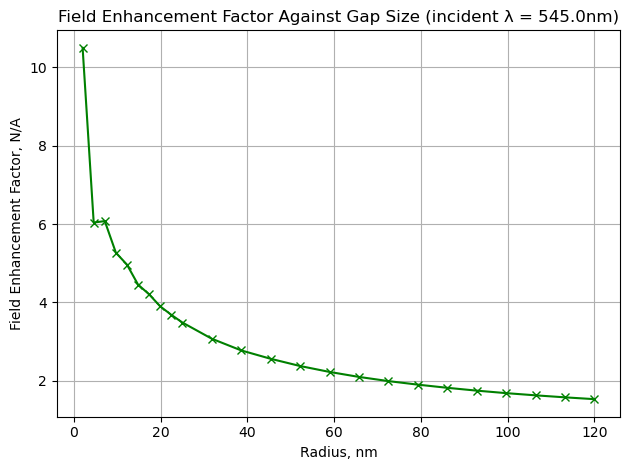

In [8]:
#manual for gap vary

import numpy as np
import matplotlib.pyplot as plt

wvl = 545E-3
r = 50E-3


FEF_values_man = [1.531175328271662, 1.5776426104329844, 1.6288288379475897, 1.6849860807852373, 1.748794012395692, 1.8211466819518798, 1.9018609388034964, 1.9922222812243184, 2.0991352019001255, 2.2263692910119803, 2.377310933883673, 2.561947529571016, 2.775582071620207, 3.0738478968673824, 3.4882587543060692, 3.6847819013431913, 3.900860937360002, 4.20704906726499, 4.456877405416683, 4.966562554269961, 5.2715251438871835, 6.077814085540926, 6.040190525038229, 10.5]

gaps_man = [
    120.0, 113.21428571, 106.42857143, 99.64285714, 92.85714286,
    86.07142857, 79.28571429, 72.5, 65.71428571, 58.92857143,
    52.14285714, 45.35714286, 38.57142857, 31.78571429, 25.0,
    22.44444444, 19.88888889, 17.33333333, 14.77777778, 12.22222222,
    9.66666667, 7.11111111, 4.55555556, 2.0
]



plt.figure()
plt.plot(gaps_man, FEF_values_man, "x-g")
plt.grid(True, which="both", ls="-")
plt.xlabel("Radius, nm")
plt.ylabel("Field Enhancement Factor, N/A")
plt.title(f"Field Enhancement Factor Against Gap Size (incident λ = {wvl*1E3}nm)")
plt.tight_layout()

plt.savefig(fname="MANUAL Field Enhancement Factor Against Gap Size",
        dpi=150, 
        bbox_inches="tight")
